# Feature Engineering Imdb-MovieLens

A partir de los datos generados en los notebooks (1) y (2), hacemos un análisis exploratorio. Armamos nuevas features y eliminamos features redundantes. La idea es pasar a un conjunto de datos apto para clusterizar y armar un sistema de recomendación.

(1) : https://colab.research.google.com/drive/1G2LjoUOHJsEPHQ5kOnZ_i9yP6IreKDye#scrollTo=a273df58

(2) : https://colab.research.google.com/drive/1guwxKF93HumTEaM53Pvgdsxm5OLeVUUU#scrollTo=bB1tUSQZ8xQm

# 1. Cargamos los Datos

Comenzamos importando los paquetes y los datos necesarios

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
# Cargamos los datos mergeados de Imdb y MovieLens
files_dir = './data'
merge_data_fname = 'data_movielens+imdb.csv'

df_movies = pd.read_csv(os.path.join(files_dir, merge_data_fname), na_values='nan')

In [3]:
# Cargamos los ratings de MovieLens
ratings_fname = 'ratings.csv'
df_ratings = pd.read_csv(os.path.join(files_dir, ratings_fname))

Visualizamos los datos y su estructura: comenzamos por el dataset de películas

In [4]:
print(f'El tamaño del dataset de películas es: {df_movies.shape}')
df_movies.head()

El tamaño del dataset de películas es: (50047, 15)


,movieId,title,genres_x,imdbId,tmdbId,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...",114709,862.0,Toy Story,Toy Story,0.0,1995.0,81.0,"['Adventure', 'Animation', 'Comedy']",8.3,965708.0,['John Lasseter'],['John Lasseter' 'Pete Docter' 'Andrew Stanton...
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']",113497,8844.0,Jumanji,Jumanji,0.0,1995.0,104.0,"['Adventure', 'Comedy', 'Family']",7.0,337453.0,['Joe Johnston'],['Jonathan Hensleigh' 'Greg Taylor' 'Jim Strai...
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']",113228,15602.0,Grumpier Old Men,Grumpier Old Men,0.0,1995.0,101.0,"['Comedy', 'Romance']",6.6,27243.0,['Howard Deutch'],['Mark Steven Johnson']
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']",114885,31357.0,Waiting to Exhale,Waiting to Exhale,0.0,1995.0,124.0,"['Comedy', 'Drama', 'Romance']",5.9,10877.0,['Forest Whitaker'],['Terry McMillan' 'Ronald Bass']
4,5,Father of the Bride Part II (1995),['Comedy'],113041,11862.0,Father of the Bride Part II,Father of the Bride Part II,0.0,1995.0,106.0,"['Comedy', 'Family', 'Romance']",6.0,37702.0,['Charles Shyer'],['Albert Hackett' 'Frances Goodrich' 'Nancy Me...


# 2. Feature Engineering sobre datos de películas (Imdb+MoviLens)

## Visualización de features

In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50047 entries, 0 to 50046
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         50047 non-null  int64  
 1   title           50047 non-null  object 
 2   genres_x        50047 non-null  object 
 3   imdbId          50047 non-null  int64  
 4   tmdbId          49991 non-null  float64
 5   primaryTitle    50047 non-null  object 
 6   originalTitle   50047 non-null  object 
 7   isAdult         50047 non-null  float64
 8   startYear       50044 non-null  float64
 9   runtimeMinutes  49938 non-null  float64
 10  genres_y        50014 non-null  object 
 11  averageRating   50017 non-null  float64
 12  numVotes        50017 non-null  float64
 13  directors       50047 non-null  object 
 14  writers         50047 non-null  object 
dtypes: float64(6), int64(2), object(7)
memory usage: 5.7+ MB


Vemos que tenemos varias columnas sobre las cuales podemos hacer estadística y otras que tenemos que decidir si nos quedamos o no. Comencemos limpiando las columnas que dan info redundante:

Antes que nada, eliminamos las películas cuya etiqueta 'isAdult' es 1 (son solo 36) y eliminamos ese feature.

In [6]:
n_adult_movies = df_movies[df_movies['isAdult']==1.0].shape[0]
print(f'Películas para adultos: {n_adult_movies}')

df_movies = df_movies[df_movies['isAdult']==0.0]
print(f'Cantidad de películas excluyendo a las de adultos: {df_movies.shape[0]}')


Películas para adultos: 36
Cantidad de películas excluyendo a las de adultos: 50011


In [7]:
df_movies.drop(['isAdult'], axis=1, inplace=True)
df_movies.shape

(50011, 14)

Además las columnas imdbId y tmdbId no son necesarias

In [8]:
df_movies.drop(['tmdbId'], axis=1, inplace=True)
df_movies.shape

(50011, 13)

## Títulos

Vemos que los títulos figuran en tres columnas distintas, y solo una tiene datos para todas las películas -title-.

Antes de tirar, veamos los formatos de cada una:

In [9]:
df_movies.title.value_counts()

The Reunion (2011)                2
Black Field (2009)                2
Beneath (2013)                    2
Blood Money (2017)                2
The Angel (2018)                  2
                                 ..
Figures in a Landscape (1970)     1
Barocco (1976)                    1
War Horse (2011)                  1
Rum Diary, The (2011)             1
Women of Devil's Island (1962)    1
Name: title, Length: 49950, dtype: int64

Vemos que en 'title' tenemos información sobre el título, el título original entre paréntesis y el año. En principio tenemos la info de las dos otras columnas de títulos, más el de la columna 'startYear'. Esto hace que si hay películas que son remakes, se diferencien solamente con el título.

Veamos las otras dos:

In [10]:
df_movies.primaryTitle.value_counts()

Hamlet                             9
Home                               8
Cinderella                         8
Revenge                            7
The Intruder                       7
                                  ..
Icarus XB 1                        1
Men in Hope                        1
Spud                               1
The Murderer Lives at Number 21    1
Women of Devil's Island            1
Name: primaryTitle, Length: 46403, dtype: int64

Vemos que acá varios títulos se repiten, provenientes de diferentes versiones de una misma película. Además, tenemos títulos faltantes. 

Por estas razones nos quedamos solamente con la columna "title".

In [11]:
df_movies.drop(['primaryTitle', 'originalTitle'], inplace=True, axis=1)

Antes de pasar a las otras columnas, veamos por qué seguimos teniendo títulos repetidos con toda esa información.

In [12]:
df_movies[df_movies['title']=='Blackout (2007)']

,movieId,title,genres_x,imdbId,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers
12693,66140,Blackout (2007),"['Horror', 'Thriller']",844666,2008.0,85.0,"['Horror', 'Mystery', 'Thriller']",5.0,3846.0,['Rigoberto Castañeda'],['Ed Dougherty']
15491,85070,Blackout (2007),['Drama'],822791,2007.0,95.0,['Drama'],5.8,583.0,['Jerry LaMothe'],['Jerry LaMothe']


Viendo los titulos encontramos que son películas distintas con el mismo nombre.

In [13]:
df_movies[df_movies.duplicated(subset='title', keep=False)].sort_values(by='title')

,movieId,title,genres_x,imdbId,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers
31760,151797,Absolution (2015),"['Drama', 'Thriller']",3442634,2015.0,92.0,"['Drama', 'Thriller']",6.3,373.0,['Petri Kotwica'],['Petri Kotwica' 'Johanna Hartikainen']
27003,136696,Absolution (2015),"['Action', 'Adventure', 'Crime', 'Thriller']",3503840,2015.0,96.0,"['Action', 'Adventure', 'Crime']",4.4,3456.0,['Keoni Waxman'],['Richard Beattie' 'Keoni Waxman']
49691,207249,American Woman (2019),['Drama'],4465572,2018.0,111.0,"['Drama', 'Mystery']",6.8,6592.0,['Jake Scott'],['Brad Ingelsby']
49552,206712,American Woman (2019),['(no genres listed)'],9109492,2019.0,85.0,['Drama'],5.0,298.0,['Semi Chellas'],['Semi Chellas' 'Susan Choi']
28204,140633,Another World (2014),['Documentary'],3326110,2014.0,63.0,"['Documentary', 'History']",8.1,26.0,['Thomas Torelli'],['Thomas Torelli' 'Donye Sacco' 'Valentina Iva...
...,...,...,...,...,...,...,...,...,...,...,...
38992,174449,The Void (2016),"['Fantasy', 'Horror', 'Sci-Fi', 'Thriller']",6267458,2016.0,86.0,['Horror'],3.9,184.0,['David Cave' 'Brendan Takash' 'Christine W Ch...,['David Cave' 'Christine W Chen' 'Eric Hwang' ...
40740,179333,Veronica (2017),['Horror'],5862312,2017.0,105.0,['Horror'],6.2,40814.0,['Paco Plaza'],['Paco Plaza' 'Fernando Navarro' 'Coral Cruz']
40571,178895,Veronica (2017),"['Drama', 'Mystery', 'Thriller']",3183402,2017.0,81.0,"['Drama', 'Mystery', 'Thriller']",5.8,1404.0,['Carlos Algara' 'Alejandro Martinez-Beltran'],['Carlos Algara' 'Tomas Nepomuceno']
16676,91199,Weekend (2011),"['Drama', 'Romance']",1714210,2011.0,97.0,"['Drama', 'Romance']",7.6,30144.0,['Andrew Haigh'],['Andrew Haigh']


Removemos los casos en que la película es presumiblemente la misma, pero en un caso con datos faltantes.

In [14]:
# Remuevo los duplicados 
na_columns = [ 'startYear', 'runtimeMinutes', 'genres_y', 
              'averageRating', 'numVotes', 'directors', 'writers']
mask = (~df_movies.duplicated(subset='title', keep=False) | 
        df_movies[na_columns].notnull().any(axis=1))            
df_movies = df_movies[mask]   
df_movies.shape             

(50011, 11)

## Tratamiento datos faltantes

Miremos que datos nos quedan faltantes 

In [15]:
# Vemos cuántos NaN nos quedan por columna luego de tirar esas peliculas
df_movies.isnull().sum()

movieId             0
title               0
genres_x            0
imdbId              0
startYear           3
runtimeMinutes    109
genres_y           33
averageRating      30
numVotes           30
directors           0
writers             0
dtype: int64

In [16]:
# Eliminamos las entradas con datos faltantes en averageRating
df_movies = df_movies[df_movies['averageRating'].notna()]
df_movies.shape

(49981, 11)

Llenamos los datos faltantes en runtimeMinutes con el promedio de duración de películas del mismo director

In [17]:
directors_avg = pd.DataFrame(
    {'director' : df_movies[df_movies['runtimeMinutes'].isnull()].directors.unique()}, 
    index=df_movies[df_movies['runtimeMinutes'].isnull()].index
    )

def movie_mean(df):
  """ """
  # Inicializo lista de promedios
  means = []
  
  # Variamos la lista de directores
  for idx, item in df.iterrows():
    # Media entre peliculas del mismo director
    mean = df_movies[df_movies['directors']==str(item[0])].runtimeMinutes.mean()
    means.append(mean)
  
  return means

directors_avg['runtimeAvg'] = movie_mean(directors_avg)
directors_avg.isnull().sum()

director       0
runtimeAvg    62
dtype: int64

In [18]:
# Los restantes los llenamos con el promedio general
directors_avg.fillna(df_movies.runtimeMinutes.mean(), inplace=True)
directors_avg.runtimeAvg = directors_avg.runtimeAvg.apply(lambda x: np.round(x, decimals=2))
directors_avg

,director,runtimeAvg
624,['Ed Herzog'],95.50
672,['Barry Caillier'],100.03
837,['Izidore K. Musallam'],83.00
1365,['Chris Frieri'],100.03
4284,['Martyn Atkins'],100.03
...,...,...
49658,['Genc Berisha'],103.00
49755,['Zdenek Zelenka'],100.03
49794,['Phontharis Chotkijsadarsopon'],100.03
49938,['Sribalaji'],100.03


In [19]:
df_movies.runtimeMinutes = df_movies.runtimeMinutes.fillna(directors_avg.runtimeAvg)
df_movies.isnull().sum()

movieId            0
title              0
genres_x           0
imdbId             0
startYear          0
runtimeMinutes     0
genres_y          28
averageRating      0
numVotes           0
directors          0
writers            0
dtype: int64

## Géneros

Otras columnas con información repetida son las de genres_x y genres_y. Vemos que la primera tiene info para todas las películas y la segunda no. Podríamos tirar la segunda, pero quizás es más informativa que la primera para algunas peliculas. 

In [20]:
import re
import ast

def genres_to_list(string):
  """str(list) ---> list"""
  if isinstance(string, str):
    # Divido ignorando los corchetes
    raw_list = re.split(r",|\[|\]|\'| |\(|\)", string)

    return list(filter(None, raw_list))
  
  else:
    return string  

def genres_counter(series):
  """Returns count of different elements
  in series"""
  genres = set()
  
  for idx, value in series.items():
    if isinstance(value, list):
      genres.update(value)
  
  return genres   

df_movies['genres_x'] = df_movies['genres_x'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_movies['genres_y'] = df_movies['genres_y'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 

generos_x = genres_counter(df_movies['genres_x'])
print(f'La cantidad de generos en genres_x es: {len(generos_x)}')  

generos_y = genres_counter(df_movies['genres_y'])
print(f'La cantidad de generos en genres_y es: {len(generos_y)}')  


La cantidad de generos en genres_x es: 20
La cantidad de generos en genres_y es: 25


Por la descripción más simple de los generos, nos vamos a quedar con géneros_x, pero llenar las entradas etiquetadas con "(no genres listed)" con los generos de generos_y. Además, vamos a eliminar el genero IMAX por no ser relevante.

In [21]:
# Quitamos IMAX restandolo del set de generos
df_movies['genres_x'] = df_movies['genres_x'].apply(
    lambda x: list(set(x).difference(set(['IMAX'])))
    )

# Printeamos los generos
print(*genres_counter(df_movies['genres_x']), sep="\n")

Children
Adventure
Fantasy
Horror
Drama
Action
Musical
Thriller
Romance
Crime
Film-Noir
(no genres listed)
War
Comedy
Sci-Fi
Western
Animation
Mystery
Documentary


In [22]:
# Reemplazamos '(no genres listed)' por 0, para usar broadcasting
df_movies['genres_x'] = df_movies['genres_x'].apply(lambda x: 0 if '(no genres listed)' in set(x) else x)

# Usamos 'genres_y' si '(no genres listed)', sino dejamos igual
df_movies['genres_x'] = np.where(
    df_movies['genres_x'] == 0, 
    df_movies['genres_y'], 
    df_movies['genres_x']
    )

# Printeamos los generos
print(*genres_counter(df_movies['genres_x']), sep="\n")

Children
Music
Adventure
Fantasy
Horror
Drama
Action
Musical
Thriller
Romance
Crime
Sport
History
Film-Noir
War
Comedy
Family
Sci-Fi
Biography
Western
Animation
News
Mystery
Documentary


Simplificamos los generos: News es un tipo de documental, y siempre está acompañado de este en los generos. History viene acompañado de Documentary o de Drama, y cuando está solo corresponde a dramas.

In [23]:
# Eliminamos las peliculas sin genero restantes
df_movies = df_movies[df_movies['genres_x'].notna()]

df_movies[df_movies['genres_x'].apply(lambda x: set(x).issuperset(set(['News'])))]

,movieId,title,genres_x,imdbId,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers
25901,133321,Exile Nation: The Plastic People (2014),"[Biography, Documentary, News]",2952438,2014.0,75.0,"[Biography, Documentary, News]",7.0,42.0,['Charles Shaw'],['Charles Shaw']
27448,138180,All Eyes And Ears (2015),"[Documentary, History, News]",2505376,2015.0,90.0,"[Documentary, History, News]",7.3,23.0,['Vanessa Hope'],['Vanessa Hope']
36519,166697,You Don't Like the Truth: 4 Days Inside Guanta...,"[Documentary, History, News]",1650031,2010.0,100.0,"[Documentary, History, News]",7.2,172.0,['Luc Côté' 'Patricio Henríquez'],[nan]
36718,167340,Campaign of Hate: Russia and Gay Propaganda (2...,"[Documentary, News]",3569014,2014.0,78.0,"[Documentary, News]",5.9,110.0,['Scott Stern' 'Michael Lucas'],['Scott Stern']
36970,168236,To Be a Miss (2016),"[Documentary, Drama, News]",3472928,2016.0,84.0,"[Documentary, Drama, News]",6.4,191.0,['Flor Salcedo' 'Edward Ellis' 'Aaron Woolf'],['Edward Ellis' 'Flor Salcedo' 'Aaron Woolf']
42844,186241,Forgotten Plague (2016),"[Documentary, History, News]",4223204,2015.0,81.0,"[Documentary, History, News]",7.9,122.0,['Ryan Prior' 'Nicole Castillo'],['Ryan Prior']


In [24]:
# Eliminamos News
df_movies['genres_x'] = df_movies['genres_x'].apply(lambda x: list(set(x).difference(set(['News']))))
df_movies[df_movies['genres_x'].apply(lambda x: set(x).issuperset(set(['News'])))]

,movieId,title,genres_x,imdbId,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers


Vamos la distribución de peliculas y ratings por género.

In [25]:
# Elimino la columna genres_y y renombro genres_x
df_movies.drop(['genres_y'], axis=1, inplace=True)
df_movies.rename(columns={'genres_x' : 'genres'}, inplace=True)

df_movies

,movieId,title,genres,imdbId,startYear,runtimeMinutes,averageRating,numVotes,directors,writers
0,1,Toy Story (1995),"[Children, Adventure, Fantasy, Animation, Comedy]",114709,1995.0,81.0,8.3,965708.0,['John Lasseter'],['John Lasseter' 'Pete Docter' 'Andrew Stanton...
1,2,Jumanji (1995),"[Fantasy, Children, Adventure]",113497,1995.0,104.0,7.0,337453.0,['Joe Johnston'],['Jonathan Hensleigh' 'Greg Taylor' 'Jim Strai...
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,1995.0,101.0,6.6,27243.0,['Howard Deutch'],['Mark Steven Johnson']
3,4,Waiting to Exhale (1995),"[Drama, Comedy, Romance]",114885,1995.0,124.0,5.9,10877.0,['Forest Whitaker'],['Terry McMillan' 'Ronald Bass']
4,5,Father of the Bride Part II (1995),[Comedy],113041,1995.0,106.0,6.0,37702.0,['Charles Shyer'],['Albert Hackett' 'Frances Goodrich' 'Nancy Me...
...,...,...,...,...,...,...,...,...,...,...
50042,209155,Santosh Subramaniam (2008),"[Comedy, Action, Romance]",1382339,2008.0,177.0,7.4,1638.0,['Mohan Raja'],['Mohan Raja']
50043,209157,We (2018),[Drama],6671244,2018.0,100.0,5.6,2677.0,['Rene Eller'],['Rene Eller' 'Elvis Peeters']
50044,209159,Window of the Soul (2001),[Documentary],297986,2001.0,73.0,7.8,668.0,['João Jardim' 'Walter Carvalho'],['Walter Carvalho' 'João Jardim']
50045,209163,Bad Poems (2018),"[Drama, Comedy]",6755366,2018.0,97.0,7.5,2491.0,['Gábor Reisz'],['Gábor Reisz']


In [26]:
# Elimino de ratings las entradas cuyas peliculas no estan en df_movies
df_ratings = df_ratings[df_ratings.movieId.isin(df_movies.movieId.unique())]

In [27]:
# Cuento la cantidad de pliculas por genero
genres_count = pd.Series(df_movies.genres.sum()).value_counts()

# # Cuento la cantidad de reviews por genero
# data = df_ratings.merge(df_movies[['movieId', 'genres']], on='movieId', how='left')
# ratings_count = pd.Series(data.genres.sum())

# del data

In [28]:
#ratings_count = ratings_count.value_counts()

In [29]:
# Armo un dataset para visualizar
genres_count

Drama          24094
Comedy         14915
Thriller        7866
Romance         7147
Action          6459
Horror          5204
Crime           4950
Documentary     4679
Adventure       3536
Sci-Fi          2895
Mystery         2602
Fantasy         2183
Children        1882
War             1698
Animation       1318
Western         1107
Musical         1034
Film-Noir        352
Biography        154
History          143
Family           125
Music            109
Sport             38
dtype: int64

Para simplificar, vamos a eliminar los géneros con menos de 1000 reviews

In [30]:
# Eliminamos los generos con pocas películas
df_movies['genres'] = df_movies['genres'].apply(
    lambda x: list(set(x).difference(
        set(['Film-Noir', 'Biography', 'History', 'Family', 'Music', 'Sport'])
        )))

# Chequeamos que no hayan quedado pelis sin genero
df_movies['genres'] = df_movies['genres'].apply(
    lambda x: np.nan if x==[] else x)

df_movies['genres'].isnull().sum()

41

In [31]:
# Tiramos las películas que quedaron sin genero
df_movies = df_movies[df_movies['genres'].notna()]
df_movies.isnull().sum()

movieId           0
title             0
genres            0
imdbId            0
startYear         0
runtimeMinutes    0
averageRating     0
numVotes          0
directors         0
writers           0
dtype: int64

In [32]:
df_movies.reset_index(inplace=True)
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49927 entries, 0 to 49926
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           49927 non-null  int64  
 1   movieId         49927 non-null  int64  
 2   title           49927 non-null  object 
 3   genres          49927 non-null  object 
 4   imdbId          49927 non-null  int64  
 5   startYear       49927 non-null  float64
 6   runtimeMinutes  49927 non-null  float64
 7   averageRating   49927 non-null  float64
 8   numVotes        49927 non-null  float64
 9   directors       49927 non-null  object 
 10  writers         49927 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 4.2+ MB


## Actors names

Agregamos los actores principales (1) y las keywords (2) de cada película, para tener un recomendador más robusto. Los datos fueron obtenidos del posteo de Kaggle: 

(1)  https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/data?select=credits.csv

(2) https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/data?select=keywords.csv

In [33]:
# Cargamos actores
crew_file = 'Imdb/credits.csv.zip'
crew_path = os.path.join(files_dir, crew_file)

df_actors = pd.read_csv(crew_path, compression='zip')

# Renombramos y tiramos la crew
df_actors.drop(['crew'], axis=1, inplace=True)

# Cargamos keywords
keywords_file = 'Imdb/keywords.csv.zip'
keywords_path = os.path.join(files_dir, keywords_file)

df_key = pd.read_csv(keywords_path, compression='zip')

# Cargamos los ids de imdb
id_file = 'Imdb/movies_metadata.csv.zip'
id_path = os.path.join(files_dir, id_file)

df_id = pd.read_csv(id_path, compression='zip')
df_id = df_id[['imdb_id', 'id']]

# Renombramos y pasamos a int
df_id['id'] = df_id['id'].apply(lambda x: int(x) if '-' not in x else x)
df_id.rename({'imdb_id' : 'imdbId'}, axis=1, inplace=True)


/tmp/ipykernel_8352/491085624.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_id = pd.read_csv(id_path, compression='zip')


In [34]:
df_actors = df_actors.merge(df_id, on='id')
df_actors = df_actors.merge(df_key, on='id')

In [35]:
df_actors.dropna(inplace=True)
df_actors['imdbId'] = df_actors['imdbId'].apply(lambda x: x[2:]).astype(int)

In [36]:
df_actors

,cast,id,imdbId,keywords
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",862,114709,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",8844,113497,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",15602,113228,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...",31357,114885,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...",11862,113041,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...
46623,"[{'cast_id': 0, 'character': '', 'credit_id': ...",439050,6209470,"[{'id': 10703, 'name': 'tragic love'}]"
46624,"[{'cast_id': 1002, 'character': 'Sister Angela...",111109,2028550,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46625,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...",67758,303758,[]
46626,"[{'cast_id': 2, 'character': '', 'credit_id': ...",227506,8536,[]


In [37]:
# Pasamos todos los strings a objetos de python
df_actors['cast'] = df_actors['cast'].apply(ast.literal_eval)
df_actors['keywords'] = df_actors['keywords'].apply(ast.literal_eval)

# Me voy a quedar con los tres actores principales
df_actors['cast'] = df_actors['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_actors['cast'] = df_actors['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

# Limpiamos la columna keywords
df_actors['keywords'] = df_actors['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [38]:
df_actors.drop(['id'], axis=1, inplace=True)
df_actors

,cast,imdbId,keywords
0,"[Tom Hanks, Tim Allen, Don Rickles]",114709,"[jealousy, toy, boy, friendship, friends, riva..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",113497,"[board game, disappearance, based on children'..."
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]",113228,"[fishing, best friend, duringcreditsstinger, o..."
3,"[Whitney Houston, Angela Bassett, Loretta Devine]",114885,"[based on novel, interracial relationship, sin..."
4,"[Steve Martin, Diane Keaton, Martin Short]",113041,"[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...
46623,"[Leila Hatami, Kourosh Tahami, Elham Korda]",6209470,[tragic love]
46624,"[Angel Aquino, Perry Dizon, Hazel Orencio]",2028550,"[artist, play, pinoy]"
46625,"[Erika Eleniak, Adam Baldwin, Julie du Page]",303758,[]
46626,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",8536,[]


In [39]:
len(set(df_actors['imdbId']).intersection(set(df_movies['imdbId'])))

36868

In [40]:
df_movies = df_movies.merge(df_actors, on='imdbId', how='left')

In [41]:
df_movies.drop(['index', 'imdbId'], axis=1, inplace=True)
df_movies

,movieId,title,genres,startYear,runtimeMinutes,averageRating,numVotes,directors,writers,cast,keywords
0,1,Toy Story (1995),"[Children, Adventure, Fantasy, Animation, Comedy]",1995.0,81.0,8.3,965708.0,['John Lasseter'],['John Lasseter' 'Pete Docter' 'Andrew Stanton...,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva..."
1,2,Jumanji (1995),"[Fantasy, Children, Adventure]",1995.0,104.0,7.0,337453.0,['Joe Johnston'],['Jonathan Hensleigh' 'Greg Taylor' 'Jim Strai...,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0,101.0,6.6,27243.0,['Howard Deutch'],['Mark Steven Johnson'],"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o..."
3,4,Waiting to Exhale (1995),"[Drama, Comedy, Romance]",1995.0,124.0,5.9,10877.0,['Forest Whitaker'],['Terry McMillan' 'Ronald Bass'],"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin..."
4,5,Father of the Bride Part II (1995),[Comedy],1995.0,106.0,6.0,37702.0,['Charles Shyer'],['Albert Hackett' 'Frances Goodrich' 'Nancy Me...,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug..."
...,...,...,...,...,...,...,...,...,...,...,...
50932,209155,Santosh Subramaniam (2008),"[Comedy, Action, Romance]",2008.0,177.0,7.4,1638.0,['Mohan Raja'],['Mohan Raja'],NaN,NaN
50933,209157,We (2018),[Drama],2018.0,100.0,5.6,2677.0,['Rene Eller'],['Rene Eller' 'Elvis Peeters'],NaN,NaN
50934,209159,Window of the Soul (2001),[Documentary],2001.0,73.0,7.8,668.0,['João Jardim' 'Walter Carvalho'],['Walter Carvalho' 'João Jardim'],NaN,NaN
50935,209163,Bad Poems (2018),"[Drama, Comedy]",2018.0,97.0,7.5,2491.0,['Gábor Reisz'],['Gábor Reisz'],NaN,NaN


Arreglo features para que coincida con el dataframe de Sofi

In [42]:
# Agregamos la década
"""
Dado un año, devuelve la film decade
ej: 1906 -> 1900
    1988 -> 1980
"""
def GetDecade(year):
    film_decade = list(np.arange(1900, 2040, 10))
    interval_years_decade = list(zip(film_decade[:-1], film_decade[1:]))
    for index_decade, interval_decade in list(enumerate(interval_years_decade)):
        if (year in np.arange(interval_decade[0], interval_decade[1])):
            return film_decade[index_decade]

df_movies['film_decade'] = df_movies.startYear.apply(lambda x: GetDecade(x))

In [43]:
df_movies.to_csv(os.path.join(files_dir, 'df_movies.csv'), index=False)

# 3. Feature Engineering Datos de usuarios (MovieLens)

## Visualización de datos

Eliminamos las entradas que corresponden a películas que no estan en df_movies

In [44]:
df_ratings = df_ratings[df_ratings.movieId.isin(df_movies.movieId.unique())]
df_ratings.reset_index(inplace=True, drop=True)

In [45]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24726022 entries, 0 to 24726021
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 754.6+ MB


In [46]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

No poseemos datos nulos, veamos si tenemos duplicados

In [47]:
df_ratings.duplicated().sum()

0

Veamos como se distribuyen la cantidad de puntuaciones por usuario. Para eso agregamos un nuevo feature que asigne a cada usuario su número total de reviews.

In [48]:
df_ratings = df_ratings.merge(df_ratings.groupby('userId').
                              agg(movies_count = ('rating','count')).
                              reset_index(), on= 'userId')

In [49]:
df_ratings.head()

,userId,movieId,rating,timestamp,movies_count
0,1,296,5.0,2006-05-17,70
1,1,306,3.5,2006-05-17,70
2,1,307,5.0,2006-05-17,70
3,1,665,5.0,2006-05-17,70
4,1,899,3.5,2006-05-17,70


(1.0, 2000.0)

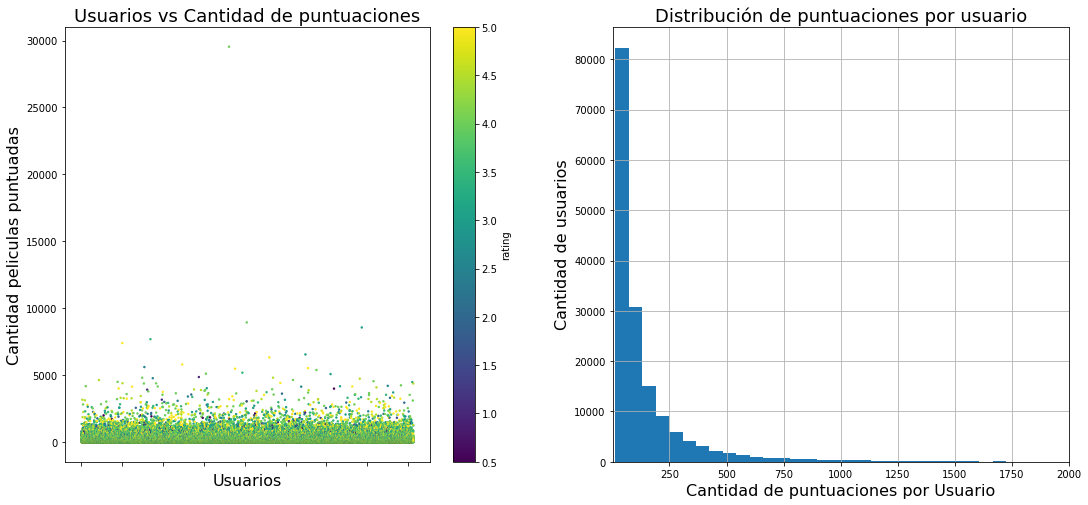

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Scatterplot
df_ratings.drop_duplicates('userId').plot.scatter(x='userId',
                      y='movies_count',
                      c='rating',
                      colormap='viridis', s=2,
                      ax=ax[0])
ax[0].set_title('Usuarios vs Cantidad de puntuaciones', size=18)
ax[0].set_xlabel('Usuarios', size=16)
ax[0].set_ylabel('Cantidad peliculas puntuadas', size=16)
ax[0].set_xticklabels([])

# Histogram
df_ratings.drop_duplicates('userId').movies_count.hist(ax=ax[1], bins=500)
ax[1].set_title('Distribución de puntuaciones por usuario', size=18)
ax[1].set_xlabel('Cantidad de puntuaciones por Usuario', size=16)
ax[1].set_ylabel('Cantidad de usuarios', size=16)
ax[1].set_xlim((1, 2000))

Vemos que tenemos outliers y que además el grueso de los usuarios puntuaron menos de 1000 veces. Tomemos un criterio de corte en cantidad de reviews para eliminar los outliers: calculamos el intercuartil (iqr) y nos quedamos con los datos dentro del intervalo $q1 - 1.5 \cdot iqr \le data\le q3 + 1.5 \cdot iqr$

In [51]:
df_ratings.movies_count.describe()

count    2.472602e+07
mean     6.005303e+02
std      1.253231e+03
min      1.200000e+01
25%      1.300000e+02
50%      3.140000e+02
75%      7.040000e+02
max      2.953800e+04
Name: movies_count, dtype: float64

In [52]:
def iqr_remove_outlier(df_in, col_name, k=1.5):
  """Remueve outliers de un dataframe calculando el 
  interquartil rate (iqr) y removiendo valores fuera
  del intervalo q1-k*iqr < data < q3+k*iqr"""
  # Calculo cuantiles 1 (.25) y 3 (.75)
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)

  # Interquartile range
  iqr = q3 - q1 

  # Intervalo de datos
  fence_low  = q1 - k * iqr
  fence_high = q3 + k*iqr

  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  
  return df_out


df_ratings = iqr_remove_outlier(df_ratings, 'movies_count')

In [53]:
df_ratings.movies_count.describe()

count    2.293834e+07
mean     4.051457e+02
std      3.656102e+02
min      1.200000e+01
25%      1.210000e+02
50%      2.810000e+02
75%      5.810000e+02
max      1.563000e+03
Name: movies_count, dtype: float64

Text(0, 0.5, 'Cantidad de usuarios')

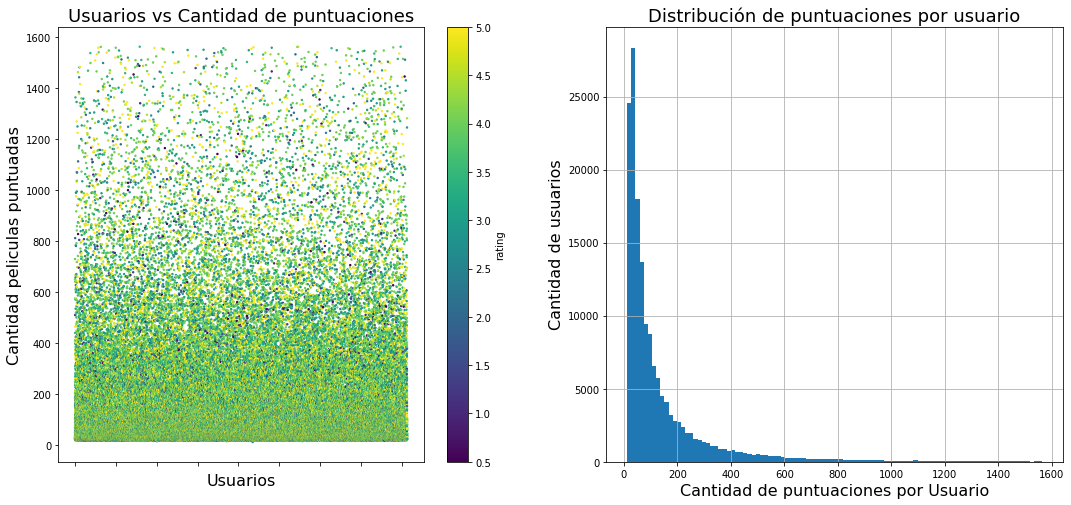

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Scatterplot
df_ratings.drop_duplicates('userId').plot.scatter(x='userId',
                      y='movies_count',
                      c='rating',
                      colormap='viridis', s=2,
                      ax=ax[0])
ax[0].set_title('Usuarios vs Cantidad de puntuaciones', size=18)
ax[0].set_xlabel('Usuarios', size=16)
ax[0].set_ylabel('Cantidad peliculas puntuadas', size=16)
ax[0].set_xticklabels([])

# Histogram
df_ratings.drop_duplicates('userId').movies_count.hist(ax=ax[1], bins=100)
ax[1].set_title('Distribución de puntuaciones por usuario', size=18)
ax[1].set_xlabel('Cantidad de puntuaciones por Usuario', size=16)
ax[1].set_ylabel('Cantidad de usuarios', size=16)


In [55]:
df_ratings.describe(datetime_is_numeric=True)

,userId,movieId,rating,movies_count
count,2.293834e+07,2.293834e+07,2.293834e+07,2.293834e+07
mean,8.128798e+04,1.977887e+04,3.561622e+00,4.051457e+02
std,4.688872e+04,3.728246e+04,1.055524e+00,3.656102e+02
min,1.000000e+00,1.000000e+00,5.000000e-01,1.200000e+01
25%,4.065500e+04,1.126000e+03,3.000000e+00,1.210000e+02
50%,8.114500e+04,2.762000e+03,4.000000e+00,2.810000e+02
75%,1.217970e+05,7.361000e+03,4.000000e+00,5.810000e+02
max,1.625410e+05,2.091710e+05,5.000000e+00,1.563000e+03


In [56]:
df_ratings.describe(datetime_is_numeric=True, include=object)

,timestamp
count,22938341
unique,8605
top,2000-11-20
freq,75396


Vemos que la cantidad mínima de votos quedó muy baja como para esperar resultados consistentes en un recomendador. Así que vamos a eliminar los usuarios con menos de 20 reviews.

In [57]:
condition = np.logical_and(df_ratings.movies_count>=20, df_ratings.movies_count<=800)
df_ratings = df_ratings[condition]
df_ratings.describe()

,userId,movieId,rating,movies_count
count,1.937251e+07,1.937251e+07,1.937251e+07,1.937251e+07
mean,8.131750e+04,1.871929e+04,3.609201e+00,2.761424e+02
std,4.689322e+04,3.623149e+04,1.051395e+00,2.062059e+02
min,1.000000e+00,1.000000e+00,5.000000e-01,2.000000e+01
25%,4.075100e+04,1.035000e+03,3.000000e+00,1.030000e+02
50%,8.126900e+04,2.605000e+03,4.000000e+00,2.220000e+02
75%,1.217990e+05,6.985000e+03,4.500000e+00,4.130000e+02
max,1.625410e+05,2.091710e+05,5.000000e+00,8.000000e+02


Inventamos features que agreguen info a a hora de clusterizar:



In [58]:
#agrego columnas de rating: promedio, cantidad de peliculas con rating y la suma.
df_ratings = df_ratings.merge(df_ratings.groupby('userId').agg(rating_mean = ('rating','mean'),
                                                               rating_std = ('rating','std'),
                                                               rating_median = ('rating','median'),
                                                               movies_count = ('rating','count')
                                                              ).reset_index(),
                              on= 'userId')
#elimino la columna timestamp
df_ratings.drop('timestamp', axis=1, inplace=True)

In [59]:
df_ratings.head(2)

,userId,movieId,rating,movies_count_x,rating_mean,rating_std,rating_median,movies_count_y
0,1,296,5.0,70,3.814286,1.004235,4.0,70
1,1,306,3.5,70,3.814286,1.004235,4.0,70


In [60]:
df_ratings.drop(["movies_count_y"], axis=1, inplace=True)
df_ratings.rename({"movies_count_x" : "movies_count"}, axis=1, inplace=True)
df_ratings.head(1)

,userId,movieId,rating,movies_count,rating_mean,rating_std,rating_median
0,1,296,5.0,70,3.814286,1.004235,4.0


Ahora armamos un dataset combinando df_ratings y df_movies, con info por usuarios para poder clusterizar.

In [61]:
# realizo un merge para completar los ratings con la informacion de las peliculas
df_movies.drop(["title", "writers", "keywords", "cast"], axis=1, inplace=True)
data = df_movies.merge(df_ratings, on='movieId', how='right')

Ahora que armé los datasets para clustering, voy a eliminar algunos features de df_ratings: este dataset lo necesitamos más adelante para extraer las películas vistas por cada usuario, así que las columnas con estadísticas no nos hacen falta.

In [62]:
df_ratings.drop(["movies_count", "rating_mean",	"rating_std", "rating_median"], axis=1, inplace=True)

Guardamos los datos en un csv

In [63]:
df_ratings.to_csv(os.path.join(files_dir, 'df_ratings.csv'), index=False)

Para ahorrar ram eliminamos las variables df_ratings y df_movies

In [64]:
del df_ratings, df_movies

In [65]:
del df_actors, df_id, df_key

In [66]:
data.to_csv('./data/df_data.csv', index=False)
del data

Dividimos "data" para poder realizar las operaciones. Para eso usamos la librería Dask, que particiona el dataframe , guardando la parte con la que ba a operar en memoria y el resto en disco

In [67]:
import pandas as pd
data = pd.read_csv('./data/df_data.csv')

Agregamos features a data

In [70]:
data.head(2)

,movieId,genres,startYear,runtimeMinutes,averageRating,numVotes,directors,film_decade,userId,rating,movies_count,rating_mean,rating_std,rating_median
0,296,"['Drama', 'Comedy', 'Crime', 'Thriller']",1994.0,154.0,8.9,1988114.0,['Quentin Tarantino'],1990,1,5.0,70,3.814286,1.004235,4.0
1,306,['Drama'],1994.0,99.0,8.1,101678.0,['Krzysztof Kieslowski'],1990,1,3.5,70,3.814286,1.004235,4.0


In [69]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [71]:
data_to_merge = (data.groupby('userId').startYear).apply(lambda x : x.mode())
data = data.merge(data_to_merge, on='userId')
data.rename({'startYear_x':'startYear','startYear_y':'year_fav'}, axis=1, inplace=True)

In [72]:
# #Agrego decada favorita
data_to_merge = (data.groupby('userId').film_decade).apply(lambda x : x.mode())
data = data.merge(data_to_merge, on='userId')
data.rename({'film_decade_x':'film_decade','film_decade_y':'decade_fav'}, axis=1, inplace=True)

In [73]:
data.to_csv('./data/df_data.csv', index=False)

In [1]:
import pandas as pd
data = pd.read_csv('./data/df_data.csv')

In [2]:
#data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head(2)

,movieId,genres,startYear,runtimeMinutes,averageRating,numVotes,directors,film_decade,userId,rating,movies_count,rating_mean,rating_std,rating_median,year_fav,decade_fav,director_fav
0,296,"['Drama', 'Comedy', 'Crime', 'Thriller']",1994.0,154.0,8.9,1988114.0,['Quentin Tarantino'],1990,1,5.0,70,3.814286,1.004235,4.0,2004.0,2000,['Ingmar Bergman']
1,306,['Drama'],1994.0,99.0,8.1,101678.0,['Krzysztof Kieslowski'],1990,1,3.5,70,3.814286,1.004235,4.0,2004.0,2000,['Ingmar Bergman']


In [18]:
#del data_to_merge
#from statistics import mode
 #Agrego director favorito
#data_to_merge = (data.groupby('userId').directors).apply(lambda x : mode(x))
#data = data.merge(data_to_merge, on='userId')
data.rename({'directors_x':'directors','directors_y':'director_fav'}, axis=1, inplace=True)

In [5]:
del data_to_merge

In [ ]:
data.drop(['directors'], axis=1, inplace=True)

In [6]:
data.to_csv('./data/df_data.csv', index=False)

In [3]:
#del data_to_merge
# Agrego cantidad de peliculas puntuadas de la decada favorita
data_to_merge = (data.groupby('userId').startYear).apply(lambda x : x.value_counts().head(1).item())
data = data.merge(data_to_merge, on='userId')
data.rename({'startYear_x':'startYear','startYear_y':'decade_fav_count'}, axis=1, inplace=True)

In [4]:
del data_to_merge
#Agrego cantidad de peliculas puntuadas del director favorito
data_to_merge = (data.groupby('userId').directors).apply(lambda x : x.value_counts().head(1).item())
data = data.merge(data_to_merge, on='userId')
data.rename({'directors_x':'directors','directors_y':'director_fav_count'}, axis=1, inplace=True)

In [12]:
del data_to_merge

In [8]:
data.to_csv('./data/df_data1.csv', index=False)

In [1]:
import pandas as pd
data = pd.read_csv('./data/df_data1.csv')

In [6]:
del data_to_merge

In [2]:
#Agrego proporcion de peliculas puntuadas de decada favorita
data['decade_fav_per'] = data['decade_fav_count'] / data['movies_count']

In [3]:
#Agrego proporcion de peliculas puntuadas de director favorito
data['director_fav_per'] = data['director_fav_count'] / data['movies_count']

In [4]:
#Agrego proporcion de peliculas puntuadas de director favorito
data['director_fav_per'] = data['director_fav_count'] / data['movies_count']


In [5]:
#Agrego el desvio y la mediana del año y decada de las peliculas puntuadas
data = data.merge(data.groupby('userId').agg(year_median=('startYear','median'),
                                             year_std=('startYear','std'),
                                             film_decade_std=('film_decade','std'),
                                             film_decade_median=('film_decade','median')
                                            ).reset_index(), on='userId')

## Guardo las features de los usuarios en un nuevo dataframe
Finalmente guardo las features calculadas para los usuarios en un dataset llamado df_users, con las columnas
['userId', 'director_fav', 'film_decade_std', 'rating_std',
       'rating_mean', 'film_decade_median', 'decade_fav', 'year_std',
       'movies_count', 'director_fav_per', 'year_fav', 'decade_fav_per',
       'rating_median', 'year_median', 'decade_fav_count',
       'director_fav_count']


In [16]:
data.columns

Index(['movieId', 'genres', 'startYear', 'runtimeMinutes', 'averageRating',
       'numVotes', 'directors', 'film_decade', 'userId', 'rating',
       'movies_count', 'rating_mean', 'rating_std', 'rating_median',
       'year_fav', 'decade_fav', 'director_fav', 'decade_fav_count',
       'director_fav_count'],
      dtype='object')

In [6]:
user_features = ['userId']+list((set(data.columns)).difference(set(data.columns[:9])))
df_users = data.drop_duplicates('userId')[user_features]

In [7]:
df_users.to_csv('./data/df_users.csv', index=False)